# Stellar spectra    A. Basic Line Formation  


**Håkon Tansem**

***Instructions*** *This is the template for submitting SSA. Please update your name or student identifier above. Before you submit, make sure you delete all the markdown cells with text in italic (such as these instructions). Do not delete the questions themselves. Write your answers in the cells below the questions. While only one empty cell appears before the question blocks, feel free to add any quantity of cells (code or Markdown) in the order and quantity you see fit. You can also modify the header below to suit your needs, but please don't use any non-standard packages and do not load external code. The whole notebook must run without any errors in the code. In this first experiment with notebooks, there are no page / text limits. But please write concisely, and try to keep it short!*

In [1]:
%matplotlib inline

import numpy
import matplotlib.pyplot as plt
from cycler import cycler
from matplotlib import cm
from astropy import units
from astropy import constants
from astropy.visualization import quantity_support
from IPython.display import set_matplotlib_formats
#from atom import Atom
from astropy.io import ascii


quantity_support()
set_matplotlib_formats('svg')
plt.rc('legend', frameon=False)



class Atom:
    """
    Reads atomic data, calculates level populations according to Boltzmann's law,
    and ionisation fractions according to Saha's law.
    """
    
    def __init__(self, atomfile=None):
        """
        Parameters
        ----------
        atomfile : string, optional
            Name of file with atomic data. If not present, atomic data needs
            to be loaded with the .read_atom method.
        """
        self.loaded = False
        if atomfile:
            self.read_atom(atomfile)
        
    def read_atom(self, filename):
        """
        Reads atom structure from text file.
        
        Parameters
        ----------
        filename: string
            Name of file with atomic data.
        """
        tmp = numpy.loadtxt(filename, unpack=True)
        self.n_stages = int(tmp[2].max()) + 1
        # Get maximum number of levels in any stage
        self.max_levels = 0
        for i in range(self.n_stages):
            self.max_levels = max(self.max_levels, (tmp[2] == i).sum())
        # Populate level energies and statistical weights
        # Use a square array filled with NaNs for non-existing levels
        chi = numpy.empty((self.n_stages, self.max_levels))
        chi.fill(numpy.nan)
        self.g = numpy.copy(chi)
        for i in range(self.n_stages):
            nlevels = (tmp[2] == i).sum()
            chi[i, :nlevels] = tmp[0][tmp[2] == i]
            self.g[i, :nlevels] = tmp[1][tmp[2] == i]
        # Put units, convert from cm-1 to Joule
        chi = (chi / units.cm).to('aJ', equivalencies=units.spectral())
        # Save ionisation energies, saved as energy of first level in each stage
        self.chi_ion = chi[:, 0].copy()
        # Save level energies relative to ground level in each stage
        self.chi = chi - self.chi_ion[:, numpy.newaxis]
        self.loaded = True
        
    def compute_partition_function(self, temperature):
        """
        Computes partition functions using the atomic level energies and
        statistical weights.
        
        Parameters
        ----------
        temperature: astropy.units.quantity (scalar or array)
            Gas temperature in units of K or equivalent.
        """
        if not self.loaded:
            raise ValueError("Missing atom structure, please load atom with read_atom()")
        temp = temperature[numpy.newaxis, numpy.newaxis]  # to allow broadcast
        return numpy.nansum(self.g[..., numpy.newaxis] * 
                            numpy.exp(-self.chi[..., numpy.newaxis] / 
                                      constants.k_B / temp), axis=1)
    
    def compute_excitation(self, temperature):
        """
        Computes the level populations relative to the ground state,
        according to the Boltzmann law.
        
        Parameters
        ----------
        temperature: astropy.units.quantity (scalar or array)
            Gas temperature in units of K or equivalent.
        """
        pfunc = self.compute_partition_function(temperature)
        # Reshape arrays to allow broadcast
        temp = temperature[numpy.newaxis, numpy.newaxis]
        g_ratio = self.g[..., numpy.newaxis] / pfunc[:, numpy.newaxis]  # relative to total number of atoms in this stage
        chi = self.chi[..., numpy.newaxis]
        return g_ratio * numpy.exp(-chi / (constants.k_B * temp))
    
    def compute_ionisation(self, temperature, electron_pressure):
        """
        Computes ionisation fractions according to the Saha law.
        
        Parameters
        ----------
        temperature: astropy.units.quantity (scalar or array)
            Gas temperature in units of K or equivalent.
        electron_pressure: astropy.units.quantity (scalar)
            Electron pressure in units of Pa or equivalent.
        """
        partition_function = self.compute_partition_function(temperature)
        electron_density = electron_pressure / (constants.k_B * temperature)
        saha_const = ((2 * numpy.pi * constants.m_e * constants.k_B * temperature) / 
                      (constants.h ** 2)) ** (3 / 2)
        nstage = numpy.zeros_like(partition_function) / units.m ** 3
        nstage[0] = 1. / units.m ** 3
        # Below we use the values for ionisation energies that are saved
        # in the first index of each excited state: self.chi[r + 1, 0]
        for r in range(self.n_stages - 1):
            nstage[r + 1] = (nstage[r] / electron_density * 2 * saha_const *
                             partition_function[r + 1] / partition_function[r] * 
                             numpy.exp(-self.chi_ion[r + 1, numpy.newaxis] / 
                                       (constants.k_B * temperature[numpy.newaxis])))
        # nansum is needed because the last stage might have only one level
        # (only ionisation potential)
        return nstage / numpy.nansum(nstage, axis=0)

    def compute_populations(self, temperature, electron_pressure):
        """
        Computes relative level populations for all levels and all
        ionisation stages using the Bolzmann and Saha laws.
        
        Parameters
        ----------
        temperature: astropy.units.quantity (scalar or array)
            Gas temperature in units of K or equivalent.
        electron_pressure: astropy.units.quantity (scalar)
            Electron pressure in units of Pa or equivalent.
        """
        return (self.compute_excitation(temperature) * 
                self.compute_ionisation(temperature, electron_pressure)[:, numpy.newaxis])

    def plot_payne(self, temperature, electron_pressure):
        """
        Plots the Payne curves for the current atom.
        
        Parameters
        ----------
        temperature: astropy.units.quantity (array)
            Gas temperature in units of K or equivalent.
        electron_pressure: astropy.units.quantity (scalar)
            Electron pressure in units of Pa or equivalent.
        """
        pops = self.compute_populations(temperature, electron_pressure)
        fig, ax = plt.subplots()
        ax.plot(numpy.tile(temperature, (self.n_stages, 1)).T, pops[:, 0].T, 'b-')
        n_levels = self.chi.shape[1]
        if n_levels > 1:
            ax.plot(numpy.tile(temperature, (self.n_stages, 1)).T, pops[:, 1].T, 'r--')
        if n_levels > 2:
            ax.plot(numpy.tile(temperature, (self.n_stages, 1)).T, pops[:, 2].T, 'k:')
        ax.set_yscale('log')
        ax.set_ylim(1e-8, 1.1)
        ax.set_xlabel('Temperature (K)')
        ax.set_ylabel('Populations')

## 1. Saha-Boltzmann calibration of the Harvard sequence ("Cecilia Payne")

## 1.1 Payne’s line strength diagram

## 1.2 The Boltzmann and Saha laws

* Inspect the hydrogen energy level diagram in section 1.2. Which transitions correspond to the hydrogen lines in the image with stellar spectrograms (section 1)? Which transitions share lower levels and which share upper levels?

* Payne's basic assumption was that the strength of the absorption lines observed in stellar spectra scales with the population density of the lower level of the corresponding transition. Why would she think so? (It is not correct, but generally stellar absorption lines do get stronger at larger lower-level population. In this exercise we follow her example and assume that the scaling is linear.)

* Use this expectation to give initial rough estimates of the strength ratios of the $\alpha$ lines in the the H I Lyman, Balmer, Paschen and Brackett series.


**Answers:**

* We only have H$\beta$ in the diagram at $486.3$nm. This will share the lower level with the other balmer series in the diagram H$\delta$ and H$\gamma$. None of the transitions share upper levels.

* She probably thought that the darker an absorbtion line is, there would be more atoms in the lower level since you would then have more atoms that could be excited to a higher state. 

In [2]:
T = 5780

def ratio(g1, g2, xi1, xi2):
    return(g1 * numpy.exp(-xi1/(constants.k_B*T*units.K))
           / (g2 * numpy.exp(-xi2/(constants.k_B*T*units.K))))

g = lambda s: 2 * s**2
xi = lambda s: 13.598 * (1 - 1/s**2) * units.eV

s = numpy.arange(1,5)

g_arr   =  g(s)
xi_arr = xi(s)

for i in range(len(s)):
    for j in range(len(s)):
        if i !=j and i < j:
            r = ratio(g_arr[i], g_arr[j], xi_arr[i], xi_arr[j])
            print("n_{0:d}/n_{1:d} = {2:.3e}".format(i+1, j+1, r))


n_1/n_2 = 1.951e+08
n_1/n_3 = 3.845e+09
n_1/n_4 = 8.155e+09
n_2/n_3 = 1.970e+01
n_2/n_4 = 4.179e+01
n_3/n_4 = 2.121e+00


From this we can see that Lyman series gives the strongest absorbtion lines by far if we go with Payne´s assumption. Their ratio compared to the other series is in order of magnitude $10^8$ and $10^9$.

* Explain from equations (1) and (3) why the Saha and Boltzmann distributions behave differently for increasing temperature.
* Speculate how ionisation can fully deplete a stage while excitation puts only a few atoms in levels just below the ionisation level. Hint: what is the limit of the Saha and Boltzman ratios for infinite temperature?

*Answers:*

* From equation (1), we have $\frac{n_{r,s}{N_r}}{N_r}=\frac{g_{r,s}}{U_r}e^{-\chi/kT}$, and from equation (3) we have $\frac{N_{r+1}}{N_r}=\frac{1}{N_e}\frac{2U_{r+1}}{U_r}(\frac{2\pi m_e kT}{h^2})^{3/2}e^{-\chi_r/kT}$. We can see that the Saha law includes an extra T$^{3/2}$ term and will therefore behave differently than the boltsmann distribution. We also have a temperature dependency in $U_r$ where we sum over factors of $e^{-\chi_r/kT}$ in the Boltzmann ratio. In the saha ratio we also have $U_{r+1}$ as well as $U_r$.

* The Boltzmann ratio as a function of $T$ behaves as $r_B\propto e^{\chi/kT}$ and the Saha ratio behaves as $r_S\propto T^{3/2}e^{\chi/kT}$ where $r_B$ and $r_S$ denotes the Boltzmann and the Saha rations respectively. One can clearly see that the Boltzmann ratio converges to a constant as the temperature increases. The Saha ratio on the other hand goes to infinity as $T$ goes to infinity. When the Saha distribution goes to infinity as the temperature goes to infinity, we will have "infinately" more electrons on ionisation stage $r+1$ than on stage $r$. This means that as the temperature increases more and more atoms will be ionised untill all atoms are ionised. When all atoms are ionised all lower levels are fully depleted. For the boltzmann ratio we have a dependency on $\chi$ in the exponent. For higher ionisation levels this $\chi$ becomes larger thus reducing the weight to this contribution since the since we have negative sign in the exponent. 
$$\frac{n_{r,s}}{N_r} = \frac{g_{r,s}}{U_r} \mathrm{e}^{-\chi_{r,s}/kT}$$
We see from the formula that the larger the ionisation level, the larger the $\chi$ thereby giving a smaller ratio.

## 1.3 Saha-Boltzmann populations of a simplified Ca atom

### 1.3.1 Partition function 

### 1.3.2 Compute the level populations according to the Boltzmann law

### 1.3.3 Compute the ionisation fractions according to the Saha law

### 1.3.4 Put things on an atom class

* Using the simplified Ca atom (`Ca_atom.txt`), compute the partition functions $U_r$ for T=5000, 10000, and 20000 K. What can you say about the temperature dependence of $U_r$?

* Plot a "Payne curve" for the simplified Ca atom using the same temperature range (100 - 175.000 K) and electron pressure (100 Pa)

* Make a separate figure with a Payne curve for an element of your choice. You can choose one of the existing model atoms, or you can use the [NIST atomic spectra database](https://physics.nist.gov/PhysRefData/ASD/levels_form.html) to build a model for any atom you'd like. How does it compare with Ca?

**Answers:**



In [58]:
Ca = Atom("Ca_atom.txt")
#Ca.read_atom("Ca_atom.txt")

T = numpy.array([5000, 10000, 20000]) * units.K
Ca.compute_partition_function(T)

<Quantity [[ 1.16887479,  3.45978054, 13.62723508],
           [ 2.19889031,  3.55230978,  6.70522905],
           [ 1.        ,  1.        ,  1.00001079],
           [ 4.8153548 ,  5.2769924 ,  5.59816828],
           [ 6.91356975,  8.0815264 ,  9.64653602],
           [ 2.        ,  2.        ,  2.        ]]>

Since we have $U_r=\sum_sg_{r,s}e^{-\chi/kT}$, we can see that as the temperature increases the exponential function gets closer and closer to one. This will make the partition function converge towards the sum over all $g_{r,s}$ which is constant.

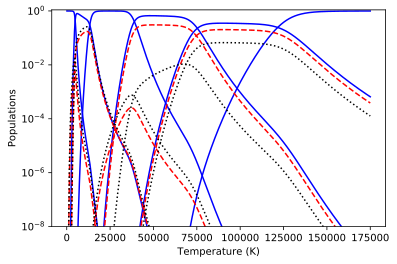

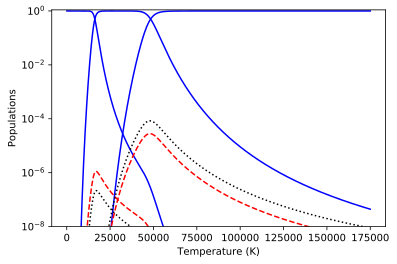

In [48]:
T = numpy.linspace(100, 175000, 1000) * units.K
Ca.plot_payne(T, 100*units.Pa)

He = Atom("He_atom.txt")
He.plot_payne(T, 100*units.Pa)

Above there is shown a plot of the payne curve for Calsium and Helium. We can see from these figures that helium has only three ionization stages as it only has two electrons in the neutral state. Calsium on the other hand has alot more and this curve shows six ionization stages. One can also see from the dotted and slashed lines that Calsium has alot higher population for electrons in excited levels. One can also see that the population for the ionization stages I, II and III reaches its peak at much lower temperatures for calsium than for Helium.

## 1.4 Saha-Boltzmann Populations of Hydrogen

* Using equations (4) and (5), create a model hydrogen atom with 100 levels and save it to a file with the same format. Compute the partition functions for both `H_atom.txt` and your 100-level model. How do they compare?

*Answers:*


In [5]:
s = numpy.arange(1,101)

g_arr = g(s)
chi_arr = xi(s).to("1/cm",equivalencies=units.spectral())
stage = numpy.zeros(len(s))
stage[-1] = 1
g_arr[-1] = 1

ascii.write([chi_arr, g_arr, stage, s-1], "task1dot4.txt",
             names = ["# E (cm^-1)", "g", "stage", "level"],
             formats = {"# E (cm^-1)": "%10.3f", "g": "%10.2f", "stage": "%2.2f", "level": "d" },
             overwrite = True,
             format="fixed_width",
             bookend = False,
             delimiter = None)

H_selfmade    = Atom("task1dot4.txt")
H_problemtext = Atom("H_atom.txt")

T = numpy.array([5780, 10000, 200000, 100000]) * units.K
print(numpy.sum(g_arr))
print(H_selfmade.compute_partition_function(T))
print(H_problemtext.compute_partition_function(T))

656701
[[2.00000093e+00 2.09260790e+00 2.98412147e+05 1.35602733e+05]
 [1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00]]
[[ 2.00000001  2.00009774 54.06876507 27.15686738]
 [ 1.          1.          1.          1.        ]]


We can see that for low temperatures the partition function remains relatively similar. As the temperature increases however, the factor $e^{-\chi_{r,s}/kT}$ gets closer and closer to one. This makes the partition function converge towards the sum over all $g_{r,s}$. In the text file *H_atom.txt* we only have six different levels. In our generated file however, we chose to use 100 levels. This makes for a larger amount of statistic weights to sum up and therefore we get a partition function with a value that is a lot larger.

## 1.5 Solar Ca$^+$K versus H$\alpha$: line strength

* Explain qualitatively why the solar Ca$^+$ K line is much stronger than the solar H$\alpha$ line, even though hydrogen is not ionised in the solar photosphere and low chromosphere ($T \approx$ 4000 - 6000 K) where these lines are formed, and even though the solar Ca/H abundance ratio is only $N_\mathrm{Ca}/N_\mathrm{H} = 2 \times 10^{−6}$. Assume again that the observed line strength scales with the lower-level population density (which it does, although nonlinearly through a "curve of growth" as you will see in an exercise below).

* Prove your explanation by computing and plotting the expected strength ratio of these two lines as function of temperature for $P_e = 10^2$ dyne cm$^{-2}$. Make use of `H_atom.txt` and `Ca_atom.txt`.


*Answers:*

If we assume Payne´s assumption the strength of a line is proportional to the population at lower levels. If we look at the ratio $$\frac{n_{Ca^+}N_{Ca}}{n_{H\alpha}N_H},$$
Where $n$ denotes the number of atoms in a given state and $N$ denotes the total number density of the corresponding atom at any ionization level. While the the ratio $N_{Ca}/N_{H}$ is small, the ratio $n_{Ca+}/n_{H\alpha}$ can be larger, making the total ratio $\frac{n_{Ca^+}N_{Ca}}{n_{H\alpha}N_H}$ larger than one.

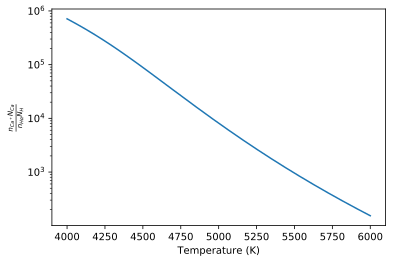

In [6]:
h_atom = Atom("H_atom.txt")
ca_atom = Atom("Ca_atom.txt")
temp = numpy.linspace(4000, 6000, 1000) * units.K

e_press = (100 *units.dyne/units.cm**2).to("Pa")

h_pops = h_atom.compute_populations(temp, e_press)
ca_pops = ca_atom.compute_populations(temp, e_press)

ratio = 2e-6 * ca_pops[1,0]/h_pops[0,1]

plt.semilogy(temp, ratio)
plt.xlabel("Temperature (K)")
plt.ylabel(r"$\frac{n_{Ca^+}N_{Ca}}{n_{H\alpha}N_H}$")
plt.show()


From this we can see thaty the population of $Ca^+$ is alot larger than $H\alpha$

## 1.6 Solar Ca$^+$K versus H$\alpha$: temperature sensitivity

* Plotting the relative population changes $(\Delta n_\mathrm{Ca} / \Delta T) / n_\mathrm{Ca}$ and $(\Delta n_\mathrm{H} /  \Delta T) / n_\mathrm{H}$ for the lower levels of Ca$^+$K and H$\alpha$, using $\Delta T=$ 1 K.

* Around $T=$ 5600 K the Ca$^+$K curve dips down to very  small values; the H$\alpha$ curve does that around $T=$ 9500  K. Thus, for $T \approx$ 5600 K the temperature sensitivity of Ca$^+$K is much smaller than the temperature sensitivity of H$\alpha$. Each dip has a $\Delta n > 0$ and a $\Delta n < 0$ flank.  Which is which? (The dips can be diagnosed by overplotting the variation with temperature of each population in relative units.) 

* Explain each flank of the two population curves and the dips in the two temperature sensitivity curves.

* Find at which temperature the hydrogen in stellar photospheres with $P_e =$ 10 Pa is about 50% ionised. Plot the neutral and ionised fractions of hydrogen as a function of temperature.

*Answers:*


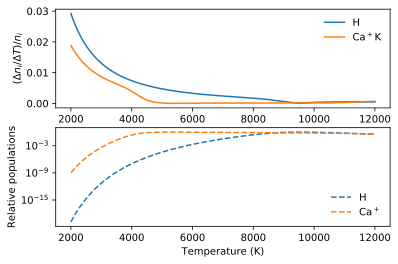

In [7]:
e_press = 10 * units.Pa
temp = numpy.linspace(2000, 12000, 1000) * units.K
dT = 1 * units.K

ca_atom = Atom("Ca_atom.txt")
n_ca1 = ca_atom.compute_populations(temp, e_press)[1, 0]
n_ca2 = ca_atom.compute_populations(temp - dT, e_press)[1, 0]
diff_ca = (n_ca1 - n_ca2) / (dT * n_ca1)

h_atom = Atom("H_atom.txt")
n_h1 = h_atom.compute_populations(temp, e_press)[0, 1]
n_h2 = h_atom.compute_populations(temp - dT, e_press)[0, 1]
diff_h = (n_h1 - n_h2) / (dT * n_h1)

fig, ax = plt.subplots(nrows=2)
ax[0].plot(temp, numpy.abs(diff_h), label=r'H')
ax[0].plot(temp, numpy.abs(diff_ca), label=r'Ca$^+$K')
ax[0].legend()
ax[0].set_ylabel(r'$(\Delta n_i / \Delta T) / n_i$')

ax[1].plot(temp, n_h1 / n_h1.max(), '--',  label='H')
ax[1].plot(temp, n_ca1 / n_ca1.max(), '--', label=r'Ca$^+$')
ax[1].set_yscale('log')
ax[1].legend()
ax[1].set_ylabel('Relative populations')
ax[1].set_xlabel('Temperature (K)');

From this figure, we can see that the derivative of the curve is positive on the left flank (temperature smaller than approximately 9000K), Thereby giving $\Delta n > 0$. This gives $\Delta n < 0$ on the right side.
Ikke glem resten av oppgavene.


In [36]:
h_pops = h_atom.compute_populations(temp, e_press)
#print(numpy.shape(h_pops[1,4,:]))
closest_index = numpy.argmin(numpy.abs(h_pops[1,0,:] - 0.5))

print(temp[closest_index])

8000.0 K


## 2. Fraunhofer line strengths and the curve of growth ("Marcel Minnaert")

    
### 2.1 The Planck law

* Plot the Planck function $B_\lambda$ for 100 $< \lambda <$ 2000 nm for a range of temperatures (5000 to 8000 K). Use a log scale for both the x and y axes. Explain the slopes of the righthand part.

*Answers:*

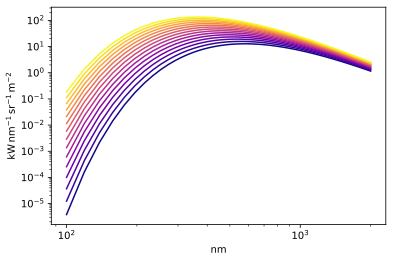

In [37]:
from astropy.modeling.blackbody import blackbody_lambda
i_units = "kW m-2 sr-1 nm-1"

wave = numpy.linspace(100, 2000, 100) * units.nm
temp = numpy.linspace(5000, 8000, 15) * units.K

# Extend wave and temp to calculate blackbody radiation all at once
radiation = blackbody_lambda(wave[:, numpy.newaxis], temp[numpy.newaxis])

fig, ax = plt.subplots()
custom_cycler = cycler('color', cm.plasma(numpy.linspace(0, 1, len(temp))))
ax.set_prop_cycle(custom_cycler)  # optional, change default colours of plots
ax.loglog(wave, radiation.to(i_units));

We can see that in the logarithmic axes the function converges to a linear slope as $\lambda$ goes to infinity. From a blackbody spectra in regular axes we can see that when the wavelength goes to infinity, $B_\lambda$ goes to zero. In logarithmic axes we will then get a linear slope that goes towards $10^{-\infty}$. Spør om dette!.

### 2.2 Radiation through an isothermal layer

* Use equation (11) to calculate the radiation through an isothermal layer. Make plots of $I_\lambda$ for the different values of $I_\lambda(0)$, using the following values:

``` python
b_lambda = 2
tau = numpy.logspace(-2, 1, 100)
i0 = numpy.arange(5)
```
    
* How does $I_\lambda$ depend on $\tau$ for $\tau \ll 1$ when $I_\lambda(0) =0$ (hint: use a log scale in the x and y axes to study the behavior at small $\tau$)?  And when $I_\lambda(0) > B_\lambda$? Such a layer with $\tau \ll 1$ is called "optically thin", why? Would "radiatively thin" be a better name?
 
* A layer is called "optically thick" when it has $\tau \gg 1$. Why? The emergent intensity becomes independent of $\tau$ for large $\tau$. Can you explain why this is so in physical terms? 

*Answer:*

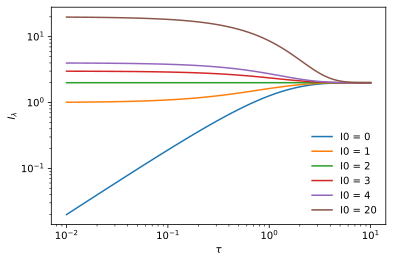

In [38]:
b_lambda = 2
tau = numpy.logspace(-2, 1, 100)
i0 = numpy.arange(0, 5, 1)

def I_lambda(tau, I0):
    return(I0*numpy.exp(-tau) + b_lambda*(1 - numpy.exp(-tau)))


for i in i0:
    plt.loglog(tau, I_lambda(tau, i), label="I0 = {0}".format(i))

plt.loglog(tau, I_lambda(tau, 20), label="I0 = 20")
plt.xlabel(r"$\tau$"); plt.ylabel(r"$I_{\lambda}$")
plt.legend()
plt.show()

If $I_{\lambda}(0)=0$, we are left with $I_{\lambda}=B_\lambda (1-e^{-\tau})$. Since the exponential factor will get closer and closer to one as $\tau$ approaches zero, the whole expressions approaches $I_{\lambda}=B_{\lambda}(1-1)=0$. When $I_\lambda(0) > B_\lambda$, as $\tau$ approaches zero we get $I_\lambda=I_\lambda(0)$. This means that the radiation emitted from the medium is more or less the same that is passed through the medium. It is called optically thin because it is easy for radiation pass through without dropping in intensity. Radiatively thin could probably be a better description as optical wavelengths are usually used when when referring to electromagnetic radiation in a specific wavelength interval. The term radiative includes all wavelengths and the case can be made that it is a better term.

When we have medium with $\tau \gg 1$, the intensity of the radiation will drop as it passes through the layer. When we have a very optically thick layer, we are only left with blackbody radiation from the surface of the layer. When $\tau$ becomes sufficiently large almost no radiation passes through. If $\tau=100$ or if $\tau=1000$ is in a sense indifferent as almost all of the radiation is extinguished by the layer anyways.   

## 2.3 Spectral lines from a solar reversing layer


### 2.3.1 Schuster-Schwarzschild model

### 2.3.2 Voigt profile

### 2.3.3 Emergent line profiles

* Compute and plot the emergent line profiles using a Schuster-Schwarzschild model, using the code provided. Try changing the parameters (`temp_surface`, `temp_layer`, `a`, `tau0`) to see if you can obtain a saturated line profile (flat bottom). Which parameter(s) are more important in determining this?

* Make a plot of line profiles with different $\tau_0$, using `tau0 = 10 ** numpy.linspace(-2, 2, 9)`. How do you explain the profile shapes for $\tau(0) \ll 1$? Why is there a low-intensity saturation limit for $\tau \gg 1$? Why do the line wings develop only for very large $\tau(0)$? Where do the wings end? For which values of $\tau(0)$ is the layer optically thin, respectively optically thick, at line center? And at $u=5$?

* Now study the dependence of these line profiles on wavelength by repeating the above for $\lambda=$ 200 nm (ultraviolet) and $\lambda=$ 1000 nm (near infrared). What sets the top value $I_{\rm cont}$ and the limit value reached at line center by $I(0)$? Check these values by computing them directly. What happens to these values at other wavelengths?  

* Make a figure with plots for the above: line profiles for several values of $\tau_0$, and the three different wavelengths (200, 500, and 1000 nm). However, normalise each line profile by its continuum intensity: `intensity /= intensity[0]` (observed spectra are usually normalised this way because absolute calibrations are often missing). Explain the wavelength dependencies in this plot.

*Answers:*

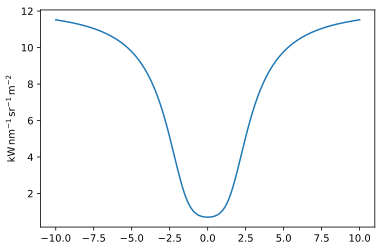

In [39]:
from scipy.special import wofz

def voigt(damping, u):
    """
    Calculates the Voigt function.
    """
    z = (u + 1j * damping)
    return wofz(z).real

temp_surface = 5777 * units.K
temp_layer = 4200 * units.K
wave = units.Quantity(300, unit='nm')
tau0 = 10*numpy.array([1.])  # thickness of reversing layer

a = 10*0.1   # Damping parameter
u = numpy.linspace(-10, 10, 201)

def compute_profile(tau0, a, u, wavelength):
    wave = wavelength[numpy.newaxis, numpy.newaxis]
    tau = tau0[numpy.newaxis] * voigt(a, u[:, numpy.newaxis])
    tau = tau[..., numpy.newaxis]
    result = (blackbody_lambda(wave, temp_surface) * numpy.exp(-tau) +
              blackbody_lambda(wave, temp_layer) * (1 - numpy.exp(-tau)))
    return numpy.squeeze(result)

intensity = compute_profile(tau0, a, u, wave)

fig, ax = plt.subplots()
ax.plot(u, intensity.to(i_units));

By changing the parameters i found that the variable `tau0` is the variable that determines wether we get saturation or not. Changing `temp_surface` or `temp_layer` only determines wether we get an emission line or absorbtion line. Changing the damping parameter `a`only determines the widt of the line. 



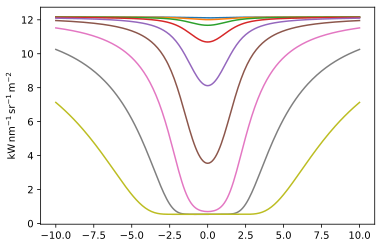

In [40]:
tau0 = 10 ** numpy.linspace(-2, 2, 9)
intensity = compute_profile(tau0, a, u, wave)

fig, ax = plt.subplots()
ax.plot(u, intensity.to(i_units));

For $\tau(0)\ll1$ we see that since our layer is radiatively thin we can see that not much radiation is absorbed. Most of it passes through the layer. The larger $\tau(0)$ becomes, the more radiation is blocked by the layer making less of it pass through. The reason for the saturation limit is because the surface of the layer itself emits black body radiation. All of the radiation entering the layer get extinguished when $\tau(0)$ becomes sufficiently large. Thus the only radiaton we would measure at a detector would be the blackbody radiation.

As to why the line wings develop for large $\tau$, we have to look at the $\tau(u)=\tau(0)V(a,u)$. Increasing $\tau(0)$ will put more weight on the Voigt function. The voigt function is a combination of a lorentzian- and gaussian function. When our function gets saturated, the peak get supressed. The edges however does not get supressed as much by the saturation and they will get more and more prominent as we multiply with a higher $\tau(0)$. Since the Voigt function includes a lorentzian term it already has prominent wings amplifying this effect.

We can see that the three lowest values of $\tau(0)$ could be classified as optically thin as only a small portion of the radiation is absorbed. The three highesr values on the other hand could definatively be classified as optically thick. on the third highest value not much radiation passes through at all. The two highest values for $\tau(0)$ is saturated and no radiation passes through. At $u=5$ we can see that none of the lines are functions are saturated. Allthough we have the highest value for $\tau(0)$ in which we could describe as optically thick at this wavelength. The second highest and third highest values would probably not be described as optically thick nor optically thin than at $u=0$. All the other would probably be described as optically thin

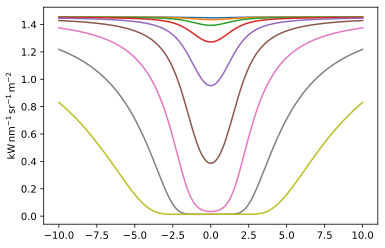

In [41]:
wave = units.Quantity(200, unit='nm')

tau0 = 10 ** numpy.linspace(-2, 2, 9)
intensity = compute_profile(tau0, a, u, wave)

fig, ax = plt.subplots()
ax.plot(u, intensity.to(i_units));

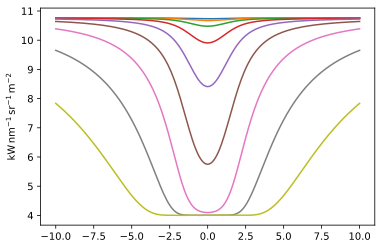

In [42]:
wave = units.Quantity(1000, unit='nm')

tau0 = 10 ** numpy.linspace(-2, 2, 9)
intensity = compute_profile(tau0, a, u, wave)

fig, ax = plt.subplots()
ax.plot(u, intensity.to(i_units));

One can see from the two above figure that the profile of the lines is exactly the same as for $300$nm. The only thing that has changed is the intensity. While we can see that there is a large intensity difference between $200$nm and $300$nm, the difference between $300$nm and $1000$nm is not as large. This shows that there is not a linear increase in intensity as wavelengths increase. This will also make the saturation occur at a higher intensity.

From the equation 
$$ I_\lambda = B_\lambda(T_{\rm surface}) \mathrm{e}^{-\tau_\lambda} 
        + B_\lambda(T_{\rm layer}) \, \left( 1 - \mathrm{e}^{-\tau_\lambda} \right),$$
one can see that $I_{cont}$, where the layer is optically thin (assume $\tau$ approaches zero) we are left with $I_\lambda = B_\lambda(T_{\rm surface})$. At the limit value at the line center $u=0$ is given when $\tau$ is large. This leaves us with $I(0)=B_\lambda(T_{\rm layer})$. We can compare these values by looking at by computing the Boltzmann functions for the different temperatures and comparing with the maximum and minimum values of our plots

In [43]:
wave = units.Quantity(200, unit='nm')
intensity = compute_profile(tau0, a, u, wave)
num_max = numpy.max(intensity).to(i_units)
num_min = numpy.min(intensity).to(i_units)
analytic_min = blackbody_lambda(wave, temp_layer).to(i_units)
analytic_max = blackbody_lambda(wave, temp_surface).to(i_units)
print("For lambda = 200nm")
print("Numerical max = {0:.3f}, Numerical min {1:.3f}".format(num_max, num_min))
print("Analyical max = {0:.3f}, Analytical min {1:.3f}".format(analytic_max, analytic_min))

wave = units.Quantity(300, unit='nm')
intensity = compute_profile(tau0, a, u, wave)
num_max = numpy.max(intensity).to(i_units)
num_min = numpy.min(intensity).to(i_units)
analytic_min = blackbody_lambda(wave, temp_layer).to(i_units)
analytic_max = blackbody_lambda(wave, temp_surface).to(i_units)
print("For lambda = 300nm")
print("Numerical max = {0:.3f}, Numerical min {1:.3f}".format(num_max, num_min))
print("Analyical max = {0:.3f}, Analytical min {1:.3f}".format(analytic_max, analytic_min))

wave = units.Quantity(500, unit='nm')
intensity = compute_profile(tau0, a, u, wave)
num_max = numpy.max(intensity).to(i_units)
num_min = numpy.min(intensity).to(i_units)
analytic_min = blackbody_lambda(wave, temp_layer).to(i_units)
analytic_max = blackbody_lambda(wave, temp_surface).to(i_units)
print("For lambda = 500m")
print("Numerical max = {0:.3f}, Numerical min {1:.3f}".format(num_max, num_min))
print("Analyical max = {0:.3f}, Analytical min {1:.3f}".format(analytic_max, analytic_min))

wave = units.Quantity(1000, unit='nm')
intensity = compute_profile(tau0, a, u, wave)
num_max = numpy.max(intensity).to(i_units)
num_min = numpy.min(intensity).to(i_units)
analytic_min = blackbody_lambda(wave, temp_layer).to(i_units)
analytic_max = blackbody_lambda(wave, temp_surface).to(i_units)
print("For lambda = 1000nm")
print("Numerical max = {0:.3f}, Numerical min {1:.3f}".format(num_max, num_min))
print("Analyical max = {0:.3f}, Analytical min {1:.3f}".format(analytic_max, analytic_min))

For lambda = 200nm
Numerical max = 1.454 kW / (m2 nm sr), Numerical min 0.014 kW / (m2 nm sr)
Analyical max = 1.454 kW / (m2 nm sr), Analytical min 0.014 kW / (m2 nm sr)
For lambda = 300nm
Numerical max = 12.162 kW / (m2 nm sr), Numerical min 0.538 kW / (m2 nm sr)
Analyical max = 12.162 kW / (m2 nm sr), Analytical min 0.538 kW / (m2 nm sr)
For lambda = 500m
Numerical max = 26.351 kW / (m2 nm sr), Numerical min 4.037 kW / (m2 nm sr)
Analyical max = 26.353 kW / (m2 nm sr), Analytical min 4.037 kW / (m2 nm sr)
For lambda = 1000nm
Numerical max = 10.761 kW / (m2 nm sr), Numerical min 4.004 kW / (m2 nm sr)
Analyical max = 10.761 kW / (m2 nm sr), Analytical min 4.004 kW / (m2 nm sr)


Since at both limits we have argued that the intensity is defined by the Planck function at the different temperatures, we should get the black body spectrum for the temperatures`temp_layer`and `temp_surface`.

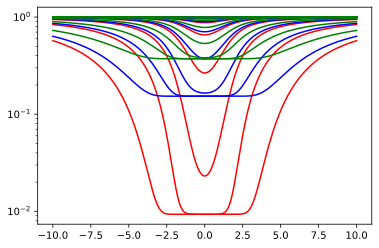

In [44]:
tau0 = 10 ** numpy.linspace(-2, 2, 9)
wave1 = units.Quantity(200, unit='nm')
wave2 = units.Quantity(500, unit='nm')
wave3 = units.Quantity(1000, unit='nm')
intensity1 = compute_profile(tau0, a, u, wave1)
intensity2 = compute_profile(tau0, a, u, wave2)
intensity3 = compute_profile(tau0, a, u, wave3)
intensity1 /= intensity1[0, 0]
intensity2 /= intensity2[0, 0]
intensity3 /= intensity3[0, 0]
fig, ax = plt.subplots()
ax.semilogy(u, intensity1,"r", label = r"$\lambda=200nm$");
ax.semilogy(u, intensity2,"b", label = r"$\lambda=500nm$");
ax.semilogy(u, intensity3,"g", label = r"$\lambda=1000nm$");

From the above plot, one can see that the wavelengths changes the saturation level. One can also see that the difference in saturation- versus continuumslevel gets larger as wavelength decreases.

## 2.4 The equivalent width of spectral lines


## 2.5 The curve of growth

* Compute and plot a curve of growth by plotting $W_\lambda$ against $\tau_0$ on a log-log plot. Explain what happens in the three different parts.  

* The first part has slope 1:1, the third part has slope 1:2 in this log-log plot.  Why?

* Which parameter controls the location of the onset of the third part? Give a rough estimate of its value for solar iron lines through comparison with the given figure from Wright (1948).

* Which parameter should you increase to produce emission lines instead of absorption lines? Change it accordingly and modify the code to produce emission profiles and an emission-line curve of growth. (To avoid taking the log of negative $W_\lambda$, plot the absolute value of $W_\lambda$.)

*Answers:*


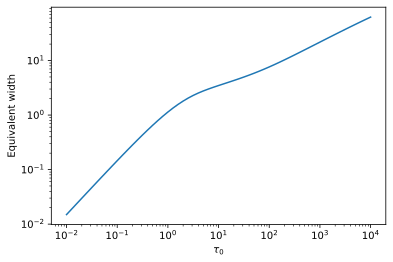

In [45]:
tau0 = numpy.logspace(-2, 4, 61)
wave = units.Quantity(500, unit='nm')
u = numpy.linspace(-200, 200, 1000)
a = 0.1

intensity = compute_profile(tau0, a, u, wave)
intensity /= intensity[0]  # normalise 

# Now we must specify axis because intensity is a 2D array
equivalent_width = numpy.trapz(1 - intensity, x=u, axis=0)

fig, ax = plt.subplots()
ax.plot(tau0, equivalent_width)
ax.set_xlabel(r'$\tau_0$')
ax.set_ylabel('Equivalent width')
ax.set_xscale('log')
ax.set_yscale('log');

This graph shows the equivalent width as a function of $\tau_0$. One can see that it starts to increase linearly as $\tau_0$ increases. As we increase $\tau_0$, the line gets more and more opaque thereby increasing the equivalent widt making it proportional to $W_\lambda\propto\tau_0$. In the middle part of the graph it starts to flatten out a bit. This is because the line starts to saturate making the increase in equivalent widt relatively small. After this the function starts to increase linearly again, but with a smaller slope than before the saturation. This because now the the wings get wider, but it doesn´t increase the equivalent width as much as it did earlier when it had not saturated yet.

The onset of the third part occurs when the line is 

The saturation level and the continuum level is determined by the $B_\lambda(T)$ function. If we can make $B_\lambda(T_{layer})>B_\lambda(T_{surface})$ we will get emission instead of absorbtion.

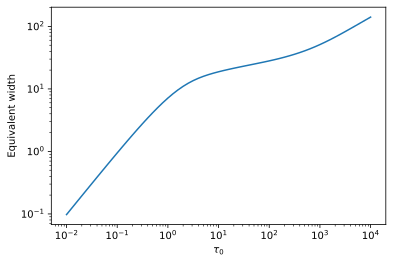

In [52]:
temp_surface = 4200 * units.K
temp_layer = 5777 * units.K

tau0 = numpy.logspace(-2, 4, 61)
wave = units.Quantity(500, unit='nm')
u = numpy.linspace(-200, 200, 1000)
a = 0.01

intensity = compute_profile(tau0, a, u, wave)
intensity /= intensity[0]  # normalise 

# Now we must specify axis because intensity is a 2D array
equivalent_width = numpy.abs(numpy.trapz(1 - intensity, x=u, axis=0))

fig, ax = plt.subplots()
ax.plot(tau0, equivalent_width)
ax.set_xlabel(r'$\tau_0$')
ax.set_ylabel('Equivalent width')
ax.set_xscale('log')
ax.set_yscale('log')

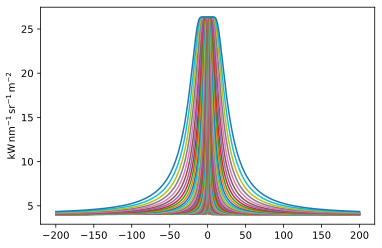

In [47]:

intensity = compute_profile(tau0, a, u, wave)

fig, ax = plt.subplots()
ax.plot(u, intensity.to(i_units));